In [189]:
%matplotlib inline

import cv2
import numpy as np
import matplotlib.pyplot as plt
import ctypes
import csv
import glob
import os
import sys
sys.path.append('/home/steve/git/CreateNormals/')
from python.calc_normals import NormalCalculation

(968, 1296, 3)


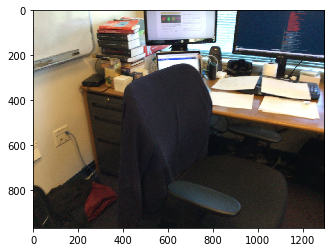

In [133]:
root_dir = '/media/steve/Seagate Backup Plus Drive/scans/'
scenename = 'scene0010_00'
filename = scenename + '/frames/frame-000000'
image = cv2.imread(root_dir + filename + '.color.jpg')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
print(image.shape)

(480, 640)
uint16


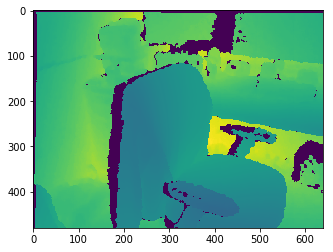

In [134]:
depth = cv2.imread(root_dir + filename + '.depth.pgm', cv2.IMREAD_ANYDEPTH)
plt.imshow(depth)
print(depth.shape)
print(depth.dtype)

[   0    1    2    3    4   16   19   22   48   52   75   77  118  131
 1163]
(480, 640)
uint16


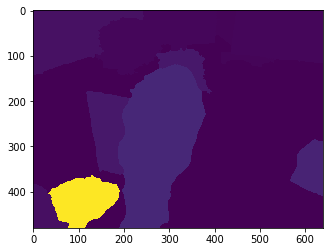

In [135]:
labels = cv2.resize(cv2.imread(root_dir + scenename + '/label-filt/0.png', cv2.IMREAD_ANYDEPTH), (640,480), interpolation=cv2.INTER_NEAREST)
#labels = cv2.imread(root_dir + 'scene0001_00/label-filt/0.png', cv2.IMREAD_ANYDEPTH)
plt.imshow(labels)
print(np.unique(labels))
print(labels.shape)
print(labels.dtype)

In [136]:
camera_params = [577.591,0,318.905,0,578.73,242.684,0,0,1]
normal_params = [5,0.02,30]
flat_labels = []
norm_calc = NormalCalculation(camera_params, normal_params, flat_labels)
normals = norm_calc.Calculate(depth, labels)

[-1.         -0.99999994 -0.9999999  ...  0.9999787   0.99998814
  0.9999974 ]


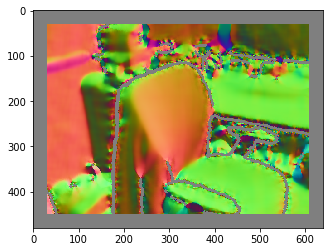

In [137]:
print np.unique(normals)
plt.imshow((normals + 1) / 2.0)

In [138]:
label_nyu_mapping = dict()
label_nyu_mapping[0] = 0
with open('/media/steve/Seagate Backup Plus Drive/scannetv2-labels.combined.tsv') as tsvfile:
    reader = csv.reader(tsvfile, delimiter='\t')
    start = True
    for row in reader:
        print(row[0] + ', ' + row[1] + ', ' + row[4] + ', ' + row[3])
        #print(row)
        if not start:
            label_nyu_mapping[int(row[0])] = int(row[4])
        start = False

id, raw_category, nyu40id, count
1, wall, 1, 8277
2, chair, 5, 4646
22, books, 23, 1678
3, floor, 2, 1553
5, door, 8, 1483
1163, object, 40, 1313
16, window, 9, 1209
4, table, 7, 1170
56, trash can, 39, 1090
13, pillow, 18, 937
15, picture, 11, 862
41, ceiling, 22, 806
26, box, 29, 775
161, doorframe, 8, 768
19, monitor, 40, 765
7, cabinet, 3, 731
9, desk, 14, 680
8, shelf, 15, 641
10, office chair, 5, 595
31, towel, 27, 570
6, couch, 6, 502
14, sink, 34, 488
48, backpack, 40, 479
28, lamp, 35, 419
11, bed, 4, 370
18, bookshelf, 10, 360
71, mirror, 19, 349
21, curtain, 16, 347
40, plant, 40, 331
52, whiteboard, 30, 327
96, radiator, 39, 322
22, book, 23, 318
29, kitchen cabinet, 3, 310
49, toilet paper, 40, 291
29, kitchen cabinets, 3, 289
23, armchair, 5, 281
63, shoes, 40, 272
24, coffee table, 7, 258
17, toilet, 33, 256
47, bag, 37, 252
32, clothes, 21, 248
46, keyboard, 40, 246
65, bottle, 40, 226
97, recycling bin, 39, 225
34, nightstand, 32, 224
38, stool, 40, 221
33, tv, 25, 219

In [139]:
#Scannet Flat Labels
# Category = ID, NYU40 ID
# Wall = 1, 1
# floor = 3, 2
# door = 5, 8
# window = 16, 9
# table = 4, 7
# picture = 15, 11
# ceiling = 41, 22
# box = 26, 29
# doorframe = 161, 8
# desk = 9, 14
# shelf = 8, 15 (maybe exclude this?)
# mirror = 71, 19
# whiteboard = 52, 30
# coffee table = 24, 7
# nightstand = 34, 32
# computer tower = 64, 40 (also telephone and cup so let's ignore this)
# fridge = 27, 24
# end table = 44, 7
# shower walls = 128, 1
# closet wall = 1165, 1


[ 0  1  2  3  5  7  9 23 30 40]


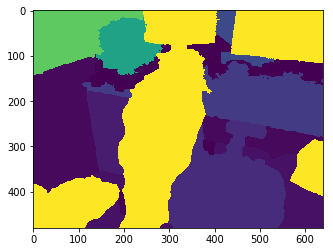

In [140]:
labels_nyu = np.array([label_nyu_mapping[x] for x in labels.flatten()])
labels_nyu = labels_nyu.reshape((480,640))
print(np.unique(labels_nyu))
plt.imshow(labels_nyu)

In [146]:
camera_params = [577.591,0,318.905,0,578.73,242.684,0,0,1]
#0.523599, 0.0472665
normal_params = [5,0.03,30,0.04]
flat_labels = [1,2,7,8,9,11,19,22,24,29,30,32]
norm_calc = NormalCalculation(camera_params, normal_params, flat_labels)
new_normals = norm_calc.Calculate(depth, labels_nyu)

[-1.         -0.99999994 -0.9999999  ...  0.99999404  0.99999523
  1.        ]


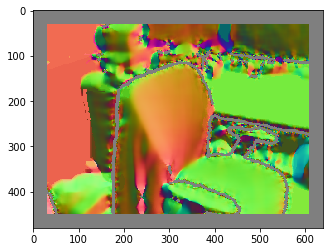

In [147]:
print np.unique(new_normals)
plt.imshow((new_normals + 1) / 2.0)

In [158]:
# We need to export a text file with all the matched files since it's a pain to do this in bash if we are missing any.s
scenes = glob.glob('/media/steve/Seagate Backup Plus Drive/scans/*')

In [190]:
with open("scannet_train.txt", "w") as text_file:
    for scene in scenes:
        rgb_files = glob.glob(scene + '/frames/*.color.jpg')
        for rgb in rgb_files:
            # for each rgb file, make sure it has a depth and label file
            split_file = rgb.split('/')
            frame_name = split_file[-1]
            path = '/'.join(split_file[:-2])
            frame_string = frame_name.split('.')[0]
            frame_number = int(frame_string.split('-')[-1])
            depth_name = path + '/frames/' + frame_string + '.depth.pgm'
            labels_name = path + '/label-filt/' + str(frame_number) + '.png'
            if os.path.isfile(depth_name) and os.path.isfile(labels_name):
                text_file.write(rgb + ',' + depth_name + ',' + labels_name + '\n')